# Model misclassification analysis

To inspect whether models perform better in certain regions of the sequence

In [21]:
import pandas as pd
import numpy as np
from collections import defaultdict
from collections import Counter
from itertools import zip_longest

import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
sns.reset_orig()

//anaconda/envs/ML_env/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
//anaconda/envs/ML_env/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [2]:
def calculate_mismatches(predict_list, target_list):
    
    '''
      Given prediction and target lists, returns mismatch_list and mismatch_indices 
    
      Args:
          prediction and target arrays. Both are 
      returns:
          mismatch_list: NUM_SEQUENCE x LEN_SEQUENCE. 1 if prediction is correct, 0 if incorrect.
          (e.g. [[0, 1, 1, 0, 0, 0, ...]])

          mismatch_indices: list of positions of mismatches (e.g. [[3, 4, 9, 13, 31]])
    '''
 
    mismatch_list = []
    for i in range(len(predict_list)):
        mismatches = (predict_list[i] != target_list[i]).astype(int)
        mismatch_list.append(np.array(mismatches))

    mismatch_indices = []
    for i in range(len(mismatch_list)):
        indices = [j for j, x in enumerate(mismatch_list[i]) if x == 1]
        mismatch_indices.append(indices)
    
    return (mismatch_list, mismatch_indices)

In [3]:
def pool_mismatches(mismatch_list, mismatch_indices):
    '''
      Given mismatch list and mismatch positions, outputs error rate over sequence length
    '''
    
    collapsed_array = []
    for item in mismatch_indices:
        collapsed_array.extend(item)

    counts = Counter(collapsed_array)

    seq_lengths = [len(item) for item in mismatch_list]
    normalizing_list = np.array([0] * max(seq_lengths))
    
    # normalizing_list[i] contains number of sequences whose length is equal/greater than (i+1)
    for length in seq_lengths:
        normalizing_list = [sum(n) for n in zip_longest(normalizing_list, [1]*length, fillvalue=0)]
    
    for i in range(max(seq_lengths)):
        counts[i] = counts[i] / normalizing_list[i]

    normalized_counts = [0] * max(seq_lengths)

    for key in counts:
        try:
            normalized_counts[key] = counts[key]
        except:
            print (key)

    return normalized_counts

In [4]:
def convert_to_triplets(seq):
    '''
      Given list of strings, returns list of lists of triplets that concetenate into the original string 
     '''
    return np.array([np.array([seq[i][j:j+3] for j in range(0, len(seq[i]), 3)]) for i in range(len(seq))])

In [5]:
def accuracy_first_36(target, predicted):
    target_sliced = np.array([seq[:12] for seq in target if len(seq) > 35])
    predicted_sliced = np.array([seq[:12] for seq in predicted if len(seq) > 35])
    
    return np.sum(target_sliced == predicted_sliced) / (12 * len(predicted_sliced))

## Human HEG 

In [6]:
# import data for human HEGs
human_targets = pd.read_csv("../outputs/predictions/human_test_split_lang.txt", header=None).iloc[:, 0]
human_unigram = pd.read_csv("../outputs/predictions/human_unigram.txt", header=None).iloc[:, 0]
human_trigram = pd.read_csv("../outputs/predictions/human_trigram.txt", header=None).iloc[:, 0]
human_fivegram = pd.read_csv("../outputs/predictions/human_fivegram.txt", header=None).iloc[:, 0]
human_ngram = pd.read_csv("../outputs/predictions/human_equally_weighted_ngram.txt", header=None).iloc[:, 0]
human_rnn = pd.read_csv("../outputs/predictions/human_rnn_bilstm_output.txt", header=None).iloc[:, 0]

In [7]:
human_target_triplets = convert_to_triplets(human_targets)
human_unigram_triplets = convert_to_triplets(human_unigram)
human_trigram_triplets = convert_to_triplets(human_trigram)
human_fivegram_triplets = convert_to_triplets(human_fivegram)
human_ngram_triplets = convert_to_triplets(human_ngram)
human_rnn_triplets = convert_to_triplets(human_rnn)

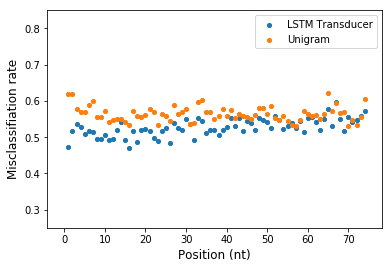

In [15]:
human_mismatch_output_unigram = calculate_mismatches(human_unigram_triplets, human_target_triplets)
human_mismatch_over_sequence_unigram = pool_mismatches(human_mismatch_output_unigram[0], human_mismatch_output_unigram[1])

human_mismatch_output_RNN = calculate_mismatches(human_rnn_triplets, human_target_triplets)
human_mismatch_over_sequence_RNN = pool_mismatches(human_mismatch_output_RNN[0], human_mismatch_output_RNN[1])

# plt.scatter(range(len(human_mismatch_over_sequence_RNN))[:75], human_mismatch_over_sequence_RNN[:75], s=17)
# plt.scatter(range(len(human_mismatch_over_sequence_unigram))[:75], human_mismatch_over_sequence_unigram[:75], s=17)

plt.plot(human_mismatch_over_sequence_RNN[:75])
plt.plot(human_mismatch_over_sequence_unigram[:75])

plt.ylim([0.25, 0.85])
plt.xlabel("Position (nt)", fontsize=12)
plt.ylabel("Misclassifiation rate", fontsize=12)
plt.legend(["LSTM Transducer", "Unigram"])

plt.show()

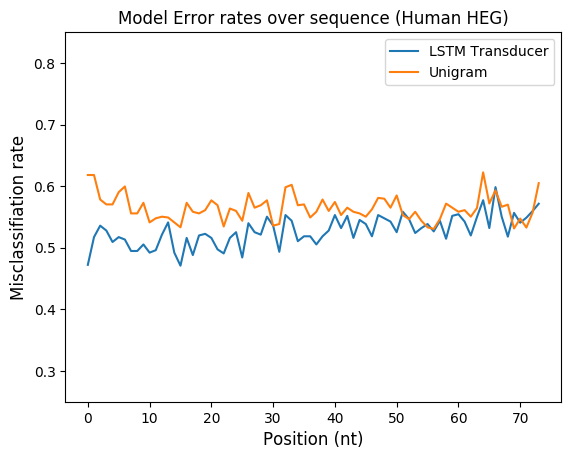

In [28]:
plt.plot(human_mismatch_over_sequence_RNN[1:75])
plt.plot(human_mismatch_over_sequence_unigram[1:75])

plt.ylim([0.25, 0.85])
plt.xlabel("Position (nt)", fontsize=12)
plt.ylabel("Misclassifiation rate", fontsize=12)
plt.legend(["LSTM Transducer", "Unigram"])

plt.title("Model Error rates over sequence (Human HEG)")
plt.savefig("error_plot.png")
plt.show()

In [9]:
print ("Accuracy of unigram in first 36 nucleotides for human heg: ", accuracy_first_36(human_target_triplets, human_unigram_triplets))

Accuracy of unigram in first 36 nucleotides for human heg:  0.46916445623342173


In [10]:
print ("Accuracy of LSTM-Transducer in first 36 nucleotides for human heg: ", accuracy_first_36(human_target_triplets, human_rnn_triplets))

Accuracy of LSTM-Transducer in first 36 nucleotides for human heg:  0.5350353669319187


## E. coli HEG

In [11]:
# import data for E. coli HEGs

ecoli_targets = pd.read_csv("../outputs/predictions/ecoli_heg_test_iterator_baseline.txt", header=None).iloc[:, 0]
ecoli_unigram = pd.read_csv("../outputs/predictions/ecoli_heg_unigram.txt", header=None).iloc[:, 0]
ecoli_trigram = pd.read_csv("../outputs/predictions/ecoli_heg_trigram.txt", header=None).iloc[:, 0]
ecoli_fivegram = pd.read_csv("../outputs/predictions/ecoli_heg_fivegram.txt", header=None).iloc[:, 0]
ecoli_ngram = pd.read_csv("../outputs/predictions/ecoli_heg_equally_weighted_ngram.txt", header=None).iloc[:, 0]
ecoli_rnn = pd.read_csv("../outputs/predictions/ecoli_heg_rnn_bilstm_output.txt", header=None).iloc[:, 0]

In [12]:
ecoli_target_triplets = convert_to_triplets(ecoli_targets)
ecoli_unigram_triplets = convert_to_triplets(ecoli_unigram)
ecoli_trigram_triplets = convert_to_triplets(ecoli_trigram)
ecoli_fivegram_triplets = convert_to_triplets(ecoli_fivegram)
ecoli_ngram_triplets = convert_to_triplets(ecoli_ngram)
ecoli_rnn_triplets = convert_to_triplets(ecoli_rnn)

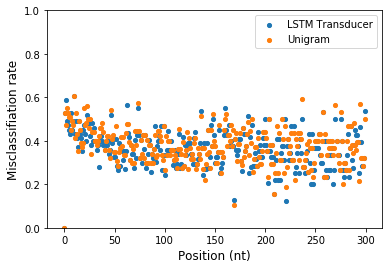

In [13]:
ecoli_mismatch_output_unigram = calculate_mismatches(ecoli_unigram_triplets, ecoli_target_triplets)
ecoli_mismatch_over_sequence_unigram = pool_mismatches(ecoli_mismatch_output_unigram[0], ecoli_mismatch_output_unigram[1])

ecoli_mismatch_output_RNN = calculate_mismatches(ecoli_rnn_triplets, ecoli_target_triplets)
ecoli_mismatch_over_sequence_RNN = pool_mismatches(ecoli_mismatch_output_RNN[0], ecoli_mismatch_output_RNN[1])

plt.scatter(range(len(ecoli_mismatch_over_sequence_RNN))[:300], ecoli_mismatch_over_sequence_RNN[:300], s=17)
plt.scatter(range(len(ecoli_mismatch_over_sequence_unigram))[:300], ecoli_mismatch_over_sequence_unigram[:300], s=17)

plt.ylim([0.0, 1.0])
plt.xlabel("Position (nt)", fontsize=12)
plt.ylabel("Misclassifiation rate", fontsize=12)
plt.legend(["LSTM Transducer", "Unigram"])

plt.show()

## Accuracy of first 36 nucleotides

In [14]:
def accuracy_first_36(target, predicted):
    target_sliced = np.array([seq[:12] for seq in target if len(seq) > 35])
    predicted_sliced = np.array([seq[:12] for seq in predicted if len(seq) > 35])
    
    return np.sum(target_sliced == predicted_sliced) / (12 * len(predicted_sliced))

In [15]:
print ("Accuracy of unigram in first 36 nucleotides for ecoli HEG: ", accuracy_first_36(ecoli_target_triplets, ecoli_unigram_triplets))

Accuracy of unigram in first 36 nucleotides for ecoli HEG:  0.5366666666666666


In [16]:
print ("Accuracy of LSTM-Transducer in first 36 nucleotides for ecoli HEG: ", accuracy_first_36(ecoli_target_triplets, ecoli_rnn_triplets))

Accuracy of LSTM-Transducer in first 36 nucleotides for ecoli HEG:  0.54


In [17]:
print ("Accuracy of unigram in first 36 nucleotides for human HEG: ", accuracy_first_36(human_target_triplets, human_unigram_triplets))

Accuracy of unigram in first 36 nucleotides for human HEG:  0.46916445623342173


In [18]:
print ("Accuracy of LSTM-Transducer in first 36 nucleotides for human HEG: ", accuracy_first_36(human_target_triplets, human_rnn_triplets))

Accuracy of LSTM-Transducer in first 36 nucleotides for human HEG:  0.5350353669319187
